# 17.3. Q-Learning

- https://d2l.ai/chapter_reinforcement-learning/qlearning.html

In the previous section, we discussed the Value Iteration algorithm which requires accessing the complete Markov decision process (MDP), e.g., the transition and reward functions. In this section, we will look at Q-Learning (Watkins and Dayan, 1992) which is an algorithm to learn the value function without necessarily knowing the MDP. This algorithm embodies the central idea behind reinforcement learning: it will enable the robot to obtain its own data.

## 17.3.1. The Q-Learning Algorithm

The value iteration for the action-value function corresponds to the update

$$Q_{k+1}(s, a) = r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s' \mid s, a) \max_{a' \in \mathcal{A}} Q_k (s', a'); \ \textrm{for all } s \in \mathcal{S} \textrm{ and } a \in \mathcal{A}.$$

As we discussed, implementing this algorithm requires knowing the MDP, specifically the transition function $P(s' \mid s, a)$. The key idea behind Q-Learning is to replace the summation over all $s' \in \mathcal{S}$ in the above expression by a summation over the states visited by the robot. This allows us to subvert the need to know the transition function.

## 17.3.2. An Optimization Problem Underlying Q-Learning

Let us imagine that the robot uses a policy $\pi_e(a \mid s)$ to take actions. It collects a dataset of $n$ trajectories of $T$ timesteps each $\{ (s_t^i, a_t^i)_{t=0,\ldots,T-1}\}_{i=1,\ldots, n}$. 

Recall that value iteration is really a set of constraints that ties together the action-value $Q^*(s, a)$ of different states and actions to each other. We can implement an approximate version of value iteration using the data that the robot has collected using $\pi_e$ as

$$\hat{Q} = \min_Q \underbrace{\frac{1}{nT} \sum_{i=1}^n \sum_{t=0}^{T-1} (Q(s_t^i, a_t^i) - r(s_t^i, a_t^i) - \gamma \max_{a'} Q(s_{t+1}^i, a'))^2}_{\stackrel{\textrm{def}}{=} \ell(Q)}.$$

Let us first observe the similarities and differences between this expression and value iteration above. If the robot's policy $\pi_e$ were equal to the optimal policy $\pi^*$, and if it collected an infinite amount of data, then this optimization problem would be identical to the optimization problem underlying value iteration. But while value iteration requires us to know $P(s' \mid s, a)$, the optimization objective does not have this term. 

We have not cheated: as the robot uses the policy $\pi_e$ to take an action $a_t^i$ at state $s_t^i$, the next state $s_{t+1}^i$ is a sample drawn from the transition function. So the optimization objective also has access to the transition function, but implicitly in terms of the data collected by the robot.

The variables of our optimization problem are $Q(s, a)$ for all $s \in \mathcal{S}$ and $a \in \mathcal{A}$. We can minimize the objective using gradient descent. For every pair $(s_t^i, a_t^i)$ in our dataset, we can write

$$\begin{aligned}Q(s_t^i, a_t^i) &\leftarrow Q(s_t^i, a_t^i) - \alpha \nabla_{Q(s_t^i,a_t^i)} \ell(Q) \\&=(1 - \alpha) Q(s_t^i,a_t^i) - \alpha \Big( r(s_t^i, a_t^i) + \gamma \max_{a'} Q(s_{t+1}^i, a') \Big),\end{aligned}$$

where $\alpha$ is the learning rate.

Typically in real problems, when the robot reaches the goal location, the trajectories end. The value of such a terminal state is zero because the robot does not take any further actions beyond this state. We should modify our update to handle such states as

$$Q(s_t^i, a_t^i) =(1 - \alpha) Q(s_t^i,a_t^i) - \alpha \Big( r(s_t^i, a_t^i) + \gamma (1 - \mathbb{1}_{s_{t+1}^i \textrm{ is terminal}} )\max_{a'} Q(s_{t+1}^i, a') \Big).$$

where $\mathbb{1}_{s_{t+1}^i \textrm{ is terminal}}$ is an indicator variable that is one if $s_{t+1}^i$ is a terminal state and zero otherwise. The value of state-action tuples $(s, a)$ that are not a part of the dataset is set to $-\infty$. This algorithm is known as **Q-Learning**.

Given the solution of these updates $\hat{Q}$, which is an approximation of the optimal value function $Q^*$, we can obtain the optimal deterministic policy corresponding to this value function easily using

$$\hat{\pi}(s) = \mathrm{argmax}_{a} \hat{Q}(s, a).$$

There can be situations when there are multiple deterministic policies that correspond to the same optimal value function; such ties can be broken arbitrarily because they have the same value function.

## 17.3.3. Exploration in Q-Learning

It is critical to pick the correct policy $\pi_e$ to collect data.

We can mitigate this concern by picking a completely random policy $\pi_e$ that samples actions uniformly randomly from $\mathcal{A}$. Such a policy would visit all states, but it will take a large number of trajectories before it does so.

We thus arrive at the second key idea in Q-Learning, namely **exploration**. Typical implementations of Q-Learning tie together the current estimate of $Q$ and the policy $\pi_e$ to set

$$\pi_e(a \mid s) = \begin{cases}\mathrm{argmax}_{a'} \hat{Q}(s, a') & \textrm{with prob. } 1-\epsilon \\ \textrm{uniform}(\mathcal{A}) & \textrm{with prob. } \epsilon,\end{cases}$$

where $\epsilon$ is called the "exploration parameter" and is chosen by the user. 

The policy $\pi_e$ is called an exploration policy. This particular $\pi_e$ is called an $\epsilon$-greedy exploration policy because it chooses the optimal action (under the current estimate $\hat{Q}$) with probability $1-\epsilon$ but explores randomly with the remainder probability $\epsilon$. 

We can also use the so-called **softmax exploration policy**

$$\pi_e(a \mid s) = \frac{e^{\hat{Q}(s, a)/T}}{\sum_{a'} e^{\hat{Q}(s, a')/T}};$$

where the hyper-parameter $T$ is called **temperature**. 

A large value of $\epsilon$ in $\epsilon$-greedy policy functions similarly to a large value of temperature $T$ for the softmax policy.

## 17.3.4. The “Self-correcting” Property of Q-Learning

The dataset collected by the robot during Q-Learning grows with time. Both the exploration policy $\pi_e$ and the estimate $\hat{Q}$ evolve as the robot collects more data. This gives us a key insight into why Q-Learning works well. 

Bad actions, e.g., ones whose value is overestimated in $\hat{Q}(s,a)$, are explored by the robot but their value is correct in the next update of the Q-Learning objective. Good actions, e.g., whose value $\hat{Q}(s, a)$ is large, are explored more often by the robot and thereby reinforced.

This property can be used to show that Q-Learning can converge to the optimal policy even if it begins with a random policy $\pi_e$ (Watkins and Dayan, 1992).

## 17.3.5. Implementation of Q-Learning

We now show how to implement Q-Learning on FrozenLake from [Gymnasium](https://gymnasium.farama.org/).

- https://gymnasium.farama.org/environments/toy_text/frozen_lake/

In [ ]:
import random
import numpy as np
import torch

In [ ]:
seed = 0  # Random number generator seed
gamma = 0.95  # Discount factor
num_iters = 256  # Number of iterations
alpha   = 0.9  # Learing rate
epsilon = 0.9  # Epsilon in epsilion gready algorithm
random.seed(seed)  # Set the random seed
np.random.seed(seed)

In [ ]:
def frozen_lake(seed):
    """Defined in :numref:`sec_utils`"""
    # See https://www.gymnasium.farama.org/environments/toy_text/frozen_lake/ to learn more about this env
    import gymnasium as gym

    env = gym.make('FrozenLake-v1', is_slippery=False)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env_info = {}
    env_info['desc'] = env.unwrapped.desc  # 2D array specifying what each grid item means
    env_info['num_states'] = env.observation_space.n  # Number of observations/states or obs/state dim
    env_info['num_actions'] = env.action_space.n  # Number of actions or action dim
    # Define indices for (transition probability, nextstate, reward, done) tuple
    env_info['trans_prob_idx'] = 0  # Index of transition probability entry
    env_info['nextstate_idx'] = 1  # Index of next state entry
    env_info['reward_idx'] = 2  # Index of reward entry
    env_info['done_idx'] = 3  # Index of done entry
    env_info['mdp'] = {}
    env_info['env'] = env

    for s, others in env.unwrapped.P.items():
        # others(s) = {a0: [ (p(s'|s,a0), s', reward, done),...], a1:[...], ...}

        for a, pxrds in others.items():
            # (trainsition probability, next state, reward, termination flag)
            # pxrds is [(p1,next1,r1,d1),(p2,next2,r2,d2),..].
            # e.g. [(0.3, 0, 0, False), (0.3, 0, 0, False), (0.3, 4, 1, False)]
            env_info['mdp'][(s, a)] = pxrds

    return env_info

In [ ]:
# Now set up the environment
env_info = frozen_lake(seed)

We first implement $\epsilon$-greedy method as follows:

In [ ]:
def e_greedy(env, Q, s, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()

    else:
        return np.argmax(Q[s,:])

We are now ready to implement Q-learning:

In [ ]:
def q_learning(env_info, gamma, num_iters, alpha, epsilon):
    env_desc = env_info['desc']  # 2D array specifying what each grid item means
    env = env_info['env']  # 2D array specifying what each grid item means
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']

    Q  = np.zeros((num_states, num_actions))
    V  = np.zeros((num_iters + 1, num_states))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        # Reset environment
        (state, _),  done = env.reset(), False
        while not done:
            # Select an action for a given state and acts in env based on selected action
            action = e_greedy(env, Q, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)

            # Q-update:
            y = reward + gamma * np.max(Q[next_state,:])
            Q[state, action] = Q[state, action] + alpha * (y - Q[state, action])

            # Move to the next state
            state = next_state
        # Record max value and max action for visualization purpose only
        for s in range(num_states):
            V[k,s]  = np.max(Q[s,:])
            pi[k,s] = np.argmax(Q[s,:])
    show_Q_function_progress(env_desc, V[:-1], pi[:-1])

In [ ]:
import matplotlib.pyplot as plt

def show_Q_function_progress(env_desc, V_all, pi_all):
    # This function visualizes how value and policy changes over time.
    # V: [num_iters, num_states]
    # pi: [num_iters, num_states]

    # We want to only shows few values
    num_iters_all = V_all.shape[0]
    num_iters = num_iters_all // 10

    vis_indx = np.arange(0, num_iters_all, num_iters).tolist()
    vis_indx.append(num_iters_all - 1)
    V = np.zeros((len(vis_indx), V_all.shape[1]))
    pi = np.zeros((len(vis_indx), V_all.shape[1]))

    for c, i in enumerate(vis_indx):
        V[c]  = V_all[i]
        pi[c] = pi_all[i]

    num_iters = V.shape[0]
    fig = plt.figure(figsize=(15, 15))
    axes = fig.subplots(4, 4)
    axes = axes.flatten()

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    for k in range(V.shape[0]):
        ax = axes[k]
        ax.imshow(V[k].reshape(4,4), cmap="bone")
        ax.set_xticks(np.arange(0, 5)-.5, minor=True)
        ax.set_yticks(np.arange(0, 5)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('on')

        # LEFT action: 0, DOWN action: 1
        # RIGHT action: 2, UP action: 3
        action2dxdy = {0:(-.25, 0),1:(0, .25),
                       2:(0.25, 0),3:(-.25, 0)}

        for y in range(4):
            for x in range(4):
                action = pi[k].reshape(4,4)[y, x]
                dx, dy = action2dxdy[action]

                if env_desc[y,x].decode() == 'H':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="y",
                         size=20, fontweight='bold')

                elif env_desc[y,x].decode() == 'G':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="w",
                         size=20, fontweight='bold')

                else:
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="g",
                         size=15, fontweight='bold')

                # No arrow for cells with G and H labels
                if env_desc[y,x].decode() != 'G' and env_desc[y,x].decode() != 'H':
                    ax.arrow(x, y, dx, dy, color='r', head_width=0.2, head_length=0.15)

        ax.set_title("Step = "  + str(vis_indx[k] + 1), fontsize=20)

    fig.tight_layout()
    plt.show()

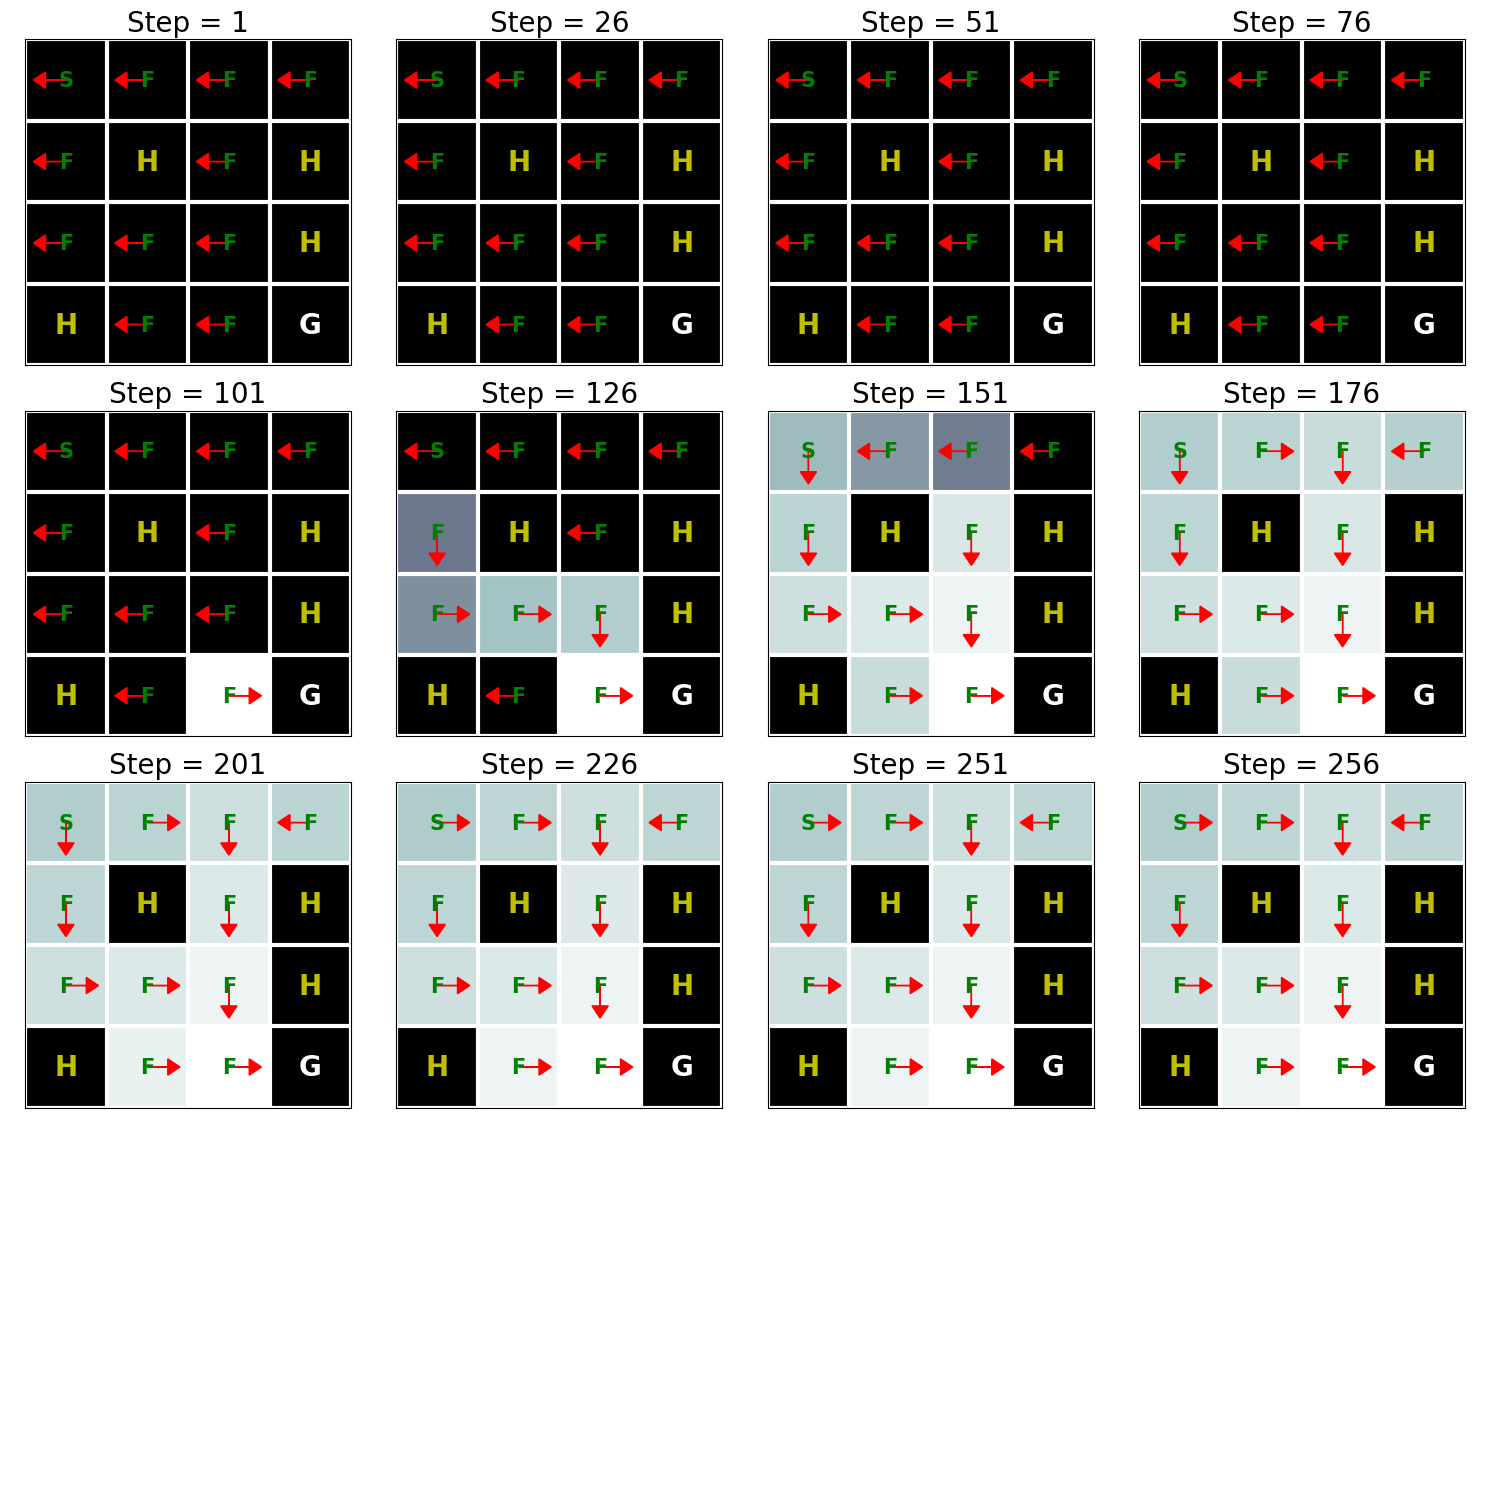

In [ ]:
q_learning(env_info=env_info, gamma=gamma, num_iters=num_iters, alpha=alpha, epsilon=epsilon)

This result shows that Q-learning can find the optimal solution for this problem roughly after 250 iterations. However, when we compare this result with the Value Iteration algorithm's result, we can see that the Value Iteration algorithm needs way fewer iterations to find the optimal solution for this problem. This happens because the Value Iteration algorithm has access to the full MDP whereas Q-learning does not.

## 17.3.6. Summary

Q-learning is one of the most fundamental reinforcement-learning algorithms. It has been at the epicenter of the recent success of reinforcement learning, most notably in learning to play video games (Mnih et al., 2013). Implementing Q-learning does not require that we know the Markov decision process (MDP), e.g., the transition and reward functions, completely.